## Import packages you need


In [1]:
# Import necessary packages.
import os
import copy
import torch
import torch.nn as nn
import torch.optim.lr_scheduler as scheduler
import torchvision.transforms as transforms
import torchvision
from PIL import Image
from matplotlib import pyplot as plt
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset, TensorDataset, Dataset
from torchvision.datasets import DatasetFolder

# If you haven't download the tqdm package, just uncomment the following line.
#!pip install tqdm
# This is for the progress bar.
from tqdm.auto import tqdm


/home/alex/miniconda3/envs/4016/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


## Show current device name


In [2]:
torch.cuda.get_device_name(0)


'NVIDIA GeForce RTX 3080 Ti'

## Dataset, Data Loader, and Transforms


In [3]:
# It is important to do data augmentation in training.
# However, not every augmentation is useful.
# Please think about what kind of augmentation is helpful for food recognition.
train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.RandomResizedCrop((128, 128)),
    # transforms.RandomCrop(size=128, padding=10),

    # Randomly flip and rotate the image
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomInvert(),

    # Randomly adjust the brightness and contrast of the image
    transforms.ColorJitter((0.875, 1.125), (0.5, 1.5), (0.5, 1.5), (-0.05, 0.05)),
    transforms.RandomAffine(degrees=15, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=(-10, 10, -10, 10)),

    # Convert the image to a tensor
    transforms.RandAugment(),
    transforms.ToTensor(),
])

# We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
test_tfm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Batch size for training, validation, and testing.
# A greater batch size usually gives a more stable gradient.
# But the GPU memory is limited, so please adjust it carefully.
batch_size = 48

# Construct datasets.
# The argument "loader" tells how torchvision reads the data.
train_set = DatasetFolder("../data/training/labeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
valid_set = DatasetFolder("../data/validation", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)
unlabeled_set = DatasetFolder("../data/training/unlabeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
test_set = DatasetFolder("../data/testing", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)

# Construct data loaders.
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)


## Training


In [4]:
class PseudoDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, id):
        return self.x[id][0], self.y[id]


In [5]:
def get_pseudo_labels(dataset, model, threshold):
    # This functions generates pseudo-label of a dataset using given model.
    # It returns an instance of DatasetFolder containing images whose prediction confidences exceed a given threshold.
    # You are NOT allowed to use any models trained on external data for pseudo-labeling.
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Construct a data loader.
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    # Make sure the model is in eval mode.
    model.eval()
    # Define softmax function.
    softmax = nn.Softmax(dim=-1)

    index = []
    label = []

    for i, batch in enumerate(tqdm(dataloader)):
        img, _ = batch

        # Forward the data
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(img.to(device))

        # Obtain the probability distributions by applying softmax on logits.
        probs = softmax(logits)

        # you may filter the data and construct a new dataset here.
        for j, x in enumerate(probs):
            if torch.max(x) > threshold:
                index.append(i * batch_size + j)
                label.append(int(torch.argmax(x)))

    # Turn off the eval mode.
    model.train()
    return PseudoDataset(Subset(dataset, index), label)


In [6]:
def model_snapshot(model, new_file=None, old_file=None):
    if os.path.exists(old_file) is True:
        os.remove(old_file)
    torch.save(model, new_file)


In [7]:
def train_model(model, do_semi, cfg, criterion, optimizer, scheduler, train_loader, valid_loader, train_set, unlabeled_set):
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    best_acc = 0.
    best_loss = 100.
    best_epoch = 0
    best_model = None
    semi_epoch = 0

    for epoch in range(cfg["n_epochs"]):
        # ---------- TODO ----------
        # In each epoch, relabel the unlabeled dataset for semi-supervised learning.
        # Then you can combine the labeled dataset and pseudo-labeled dataset for the training.
        if do_semi and best_acc > cfg["acc_th"]:
            # Obtain pseudo-labels for unlabeled data using trained model.
            pseudo_set = get_pseudo_labels(unlabeled_set, model, cfg["pseudo_th"])

            # Construct a new dataset and a data loader for training.
            # This is used in semi-supervised learning only.
            concat_dataset = ConcatDataset([train_set, pseudo_set])
            train_loader = DataLoader(concat_dataset, batch_size=cfg["batch_size"], shuffle=True, num_workers=0, pin_memory=True, drop_last=True)

        # ---------- Training ----------
        # Make sure the model is in train mode before training.
        model.train()

        # These are used to record information in training.
        train_loss = []
        train_accs = []

        # Iterate the training set by batches.
        for batch in tqdm(train_loader):

            # A batch consists of image data and corresponding labels.
            imgs, labels = batch

            # Forward the data. (Make sure data and model are on the same device.)
            logits = model(imgs.to(cfg["device"]))

            # Calculate the cross-entropy loss.
            # We don't need to apply softmax before computing cross-entropy as it is done automatically.
            loss = criterion(logits, labels.to(cfg["device"]))

            # Gradients stored in the parameters in the previous step should be cleared out first.
            optimizer.zero_grad()

            # Compute the gradients for parameters.
            loss.backward()

            # Clip the gradient norms for stable training.
            grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

            # Update the parameters with computed gradients.
            optimizer.step()

            # Compute the accuracy for current batch.
            acc = (logits.argmax(dim=-1) == labels.to(cfg["device"])).float().mean()

            # Record the loss and accuracy.
            train_loss.append(loss.item())
            train_accs.append(acc)

        # The average loss and accuracy of the training set is the average of the recorded values.
        train_loss = sum(train_loss) / len(train_loss)
        train_acc = sum(train_accs) / len(train_accs)

        # ---------- Validation ----------
        # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
        model.eval()

        # These are used to record information in validation.
        valid_loss = []
        valid_accs = []

        # Iterate the validation set by batches.
        for batch in tqdm(valid_loader):

            # A batch consists of image data and corresponding labels.
            imgs, labels = batch

            # We don't need gradient in validation.
            # Using torch.no_grad() accelerates the forward process.
            with torch.no_grad():
                logits = model(imgs.to(cfg["device"]))

            # We can still compute the loss (but not the gradient).
            loss = criterion(logits, labels.to(cfg["device"]))

            # Compute the accuracy for current batch.
            acc = (logits.argmax(dim=-1) == labels.to(cfg["device"])).float().mean()

            # Record the loss and accuracy.
            valid_loss.append(loss.item())
            valid_accs.append(acc)

        # The average loss and accuracy for entire validation set is the average of the recorded values.
        valid_loss = sum(valid_loss) / len(valid_loss)
        valid_acc = sum(valid_accs) / len(valid_accs)

        # Save the loss and accuracy for each epoch.
        history["train_loss"].append(train_loss)
        history["val_loss"].append(valid_loss)
        history["train_acc"].append(train_acc.cpu())
        history["val_acc"].append(valid_acc.cpu())

        # Dont ask, this is the only way to round the number for some reason
        if float(f"{valid_acc:.5f}") >= float(f"{best_acc:.5f}") and round(valid_loss, 5) < round(best_loss, 5):
            model_snapshot(model.state_dict(), new_file=f"{epoch + 1}_{valid_acc}.pth", old_file=f"{best_epoch + 1}_{best_acc}.pth")
            best_acc = valid_acc
            best_loss = valid_loss
            best_epoch = epoch
            best_model = copy.deepcopy(model)

        # Print the information.
        print(f"[Train | {epoch + 1:03d}/{cfg['n_epochs']:03d}] loss = {train_loss:.5f}, acc = {train_acc:.5f}, lr = {optimizer.param_groups[-1]['lr']}")
        print(f"[Valid | {epoch + 1:03d}/{cfg['n_epochs']:03d}][Best | {best_epoch + 1}] loss = {valid_loss:.5f}[{best_loss:.5f}], acc = {valid_acc:.5f}[{best_acc:.5f}]")

        # Update the scheduler.
        if best_acc < cfg["acc_th"]:
            semi_epoch = epoch
        else:
            if epoch >= semi_epoch + 30:
                scheduler.step(valid_acc)

        if epoch - best_epoch >= cfg["ending_th"]:
            break

    # Return model and history for later use.
    return best_model, history


In [8]:
def concat_history(history1: dict, history2: dict):
    for key in history1.keys() & history2.keys():
        history1[key] = history1[key] + history2[key]


In [9]:
def plot_loss(history):
    plt.plot([*range(1, len(history["train_loss"]) + 1)], history["train_loss"])
    plt.plot([*range(1, len(history["val_loss"]) + 1)], history["val_loss"])
    plt.xlabel("Epoches")
    plt.ylabel("Loss")
    plt.legend(labels=["Train", "Validation"])


In [10]:
def plot_acc(history):
    plt.plot([*range(1, len(history["train_acc"]) + 1)], history["train_acc"])
    plt.plot([*range(1, len(history["val_acc"]) + 1)], history["val_acc"])
    plt.xlabel("Epoches")
    plt.ylabel("Accuracy")
    plt.legend(labels=["Train", "Validation"])


In [11]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
model = torchvision.models.efficientnet_v2_l(weights="IMAGENET1K_V1").to(device)
model.device = device

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
scheduler = scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=30, threshold=1e-3, verbose=True)

# Save history of accuracy and loss.
history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
cfg = {"device": device, "n_epochs": 2000, "batch_size": batch_size, "pseudo_th": 0.95, "acc_th": 0.85, "ending_th": 100}


In [12]:
bestd_model, train_history = train_model(model, True, cfg, criterion, optimizer, scheduler, train_loader, valid_loader, train_set, unlabeled_set)
concat_history(history, train_history)


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 001/2000] loss = 3.05704, acc = 0.27558, lr = 0.0003
[Valid | 001/2000][Best | 1] loss = 1.15864[1.15864], acc = 0.62649[0.62649]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 002/2000] loss = 1.63814, acc = 0.47579, lr = 0.0003
[Valid | 002/2000][Best | 2] loss = 0.76015[0.76015], acc = 0.74405[0.74405]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 003/2000] loss = 1.42560, acc = 0.53733, lr = 0.0003
[Valid | 003/2000][Best | 2] loss = 0.79281[0.76015], acc = 0.73859[0.74405]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 004/2000] loss = 1.30057, acc = 0.59145, lr = 0.0003
[Valid | 004/2000][Best | 4] loss = 0.70327[0.70327], acc = 0.76984[0.76984]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 005/2000] loss = 1.21817, acc = 0.61007, lr = 0.0003
[Valid | 005/2000][Best | 4] loss = 0.79308[0.70327], acc = 0.74950[0.76984]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 006/2000] loss = 1.22356, acc = 0.60830, lr = 0.0003
[Valid | 006/2000][Best | 4] loss = 0.72540[0.70327], acc = 0.76488[0.76984]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 007/2000] loss = 1.12665, acc = 0.63867, lr = 0.0003
[Valid | 007/2000][Best | 7] loss = 0.67403[0.67403], acc = 0.77827[0.77827]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 008/2000] loss = 1.08391, acc = 0.65320, lr = 0.0003
[Valid | 008/2000][Best | 7] loss = 0.75796[0.67403], acc = 0.74851[0.77827]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 009/2000] loss = 1.03350, acc = 0.67257, lr = 0.0003
[Valid | 009/2000][Best | 9] loss = 0.52900[0.52900], acc = 0.83383[0.83383]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 010/2000] loss = 0.99028, acc = 0.67928, lr = 0.0003
[Valid | 010/2000][Best | 9] loss = 0.54688[0.52900], acc = 0.82391[0.83383]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 011/2000] loss = 0.93051, acc = 0.69799, lr = 0.0003
[Valid | 011/2000][Best | 9] loss = 0.56514[0.52900], acc = 0.83135[0.83383]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 012/2000] loss = 0.96744, acc = 0.69345, lr = 0.0003
[Valid | 012/2000][Best | 9] loss = 0.65574[0.52900], acc = 0.79415[0.83383]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 013/2000] loss = 0.92989, acc = 0.69688, lr = 0.0003
[Valid | 013/2000][Best | 9] loss = 0.60930[0.52900], acc = 0.80159[0.83383]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 014/2000] loss = 0.93158, acc = 0.71645, lr = 0.0003
[Valid | 014/2000][Best | 9] loss = 0.56720[0.52900], acc = 0.80407[0.83383]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 015/2000] loss = 0.88361, acc = 0.71888, lr = 0.0003
[Valid | 015/2000][Best | 9] loss = 0.56374[0.52900], acc = 0.81548[0.83383]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 016/2000] loss = 0.86286, acc = 0.72907, lr = 0.0003
[Valid | 016/2000][Best | 9] loss = 0.64372[0.52900], acc = 0.80159[0.83383]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 017/2000] loss = 0.85109, acc = 0.72493, lr = 0.0003
[Valid | 017/2000][Best | 9] loss = 0.54012[0.52900], acc = 0.82292[0.83383]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 018/2000] loss = 0.86921, acc = 0.72079, lr = 0.0003
[Valid | 018/2000][Best | 18] loss = 0.51071[0.51071], acc = 0.84077[0.84077]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 019/2000] loss = 0.78234, acc = 0.74768, lr = 0.0003
[Valid | 019/2000][Best | 18] loss = 0.55106[0.51071], acc = 0.83284[0.84077]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 020/2000] loss = 0.77636, acc = 0.75141, lr = 0.0003
[Valid | 020/2000][Best | 18] loss = 0.54467[0.51071], acc = 0.81647[0.84077]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 021/2000] loss = 0.78910, acc = 0.74919, lr = 0.0003
[Valid | 021/2000][Best | 18] loss = 0.56092[0.51071], acc = 0.82143[0.84077]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 022/2000] loss = 0.76396, acc = 0.74914, lr = 0.0003
[Valid | 022/2000][Best | 18] loss = 0.55683[0.51071], acc = 0.82143[0.84077]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 023/2000] loss = 0.74963, acc = 0.75449, lr = 0.0003
[Valid | 023/2000][Best | 18] loss = 0.48151[0.51071], acc = 0.82788[0.84077]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 024/2000] loss = 0.74732, acc = 0.76417, lr = 0.0003
[Valid | 024/2000][Best | 24] loss = 0.47972[0.47972], acc = 0.85516[0.85516]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 025/2000] loss = 0.71745, acc = 0.77670, lr = 0.0003
[Valid | 025/2000][Best | 24] loss = 0.57187[0.47972], acc = 0.81448[0.85516]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 026/2000] loss = 0.66893, acc = 0.78958, lr = 0.0003
[Valid | 026/2000][Best | 24] loss = 0.49410[0.47972], acc = 0.82986[0.85516]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 027/2000] loss = 0.68540, acc = 0.78988, lr = 0.0003
[Valid | 027/2000][Best | 27] loss = 0.43578[0.43578], acc = 0.85863[0.85863]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 028/2000] loss = 0.68541, acc = 0.78710, lr = 0.0003
[Valid | 028/2000][Best | 27] loss = 0.45680[0.43578], acc = 0.84673[0.85863]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 029/2000] loss = 0.62804, acc = 0.79958, lr = 0.0003
[Valid | 029/2000][Best | 27] loss = 0.45923[0.43578], acc = 0.85466[0.85863]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 030/2000] loss = 0.63886, acc = 0.80748, lr = 0.0003
[Valid | 030/2000][Best | 27] loss = 0.49764[0.43578], acc = 0.85417[0.85863]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 031/2000] loss = 0.62378, acc = 0.80663, lr = 0.0003
[Valid | 031/2000][Best | 31] loss = 0.43100[0.43100], acc = 0.86260[0.86260]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 032/2000] loss = 0.58809, acc = 0.81674, lr = 0.0003
[Valid | 032/2000][Best | 31] loss = 0.46006[0.43100], acc = 0.85813[0.86260]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 033/2000] loss = 0.63713, acc = 0.80033, lr = 0.0003
[Valid | 033/2000][Best | 31] loss = 0.45820[0.43100], acc = 0.85417[0.86260]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 034/2000] loss = 0.62617, acc = 0.79756, lr = 0.0003
[Valid | 034/2000][Best | 31] loss = 0.44698[0.43100], acc = 0.84772[0.86260]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 035/2000] loss = 0.60279, acc = 0.81368, lr = 0.0003
[Valid | 035/2000][Best | 31] loss = 0.48668[0.43100], acc = 0.85565[0.86260]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 036/2000] loss = 0.60853, acc = 0.81154, lr = 0.0003
[Valid | 036/2000][Best | 31] loss = 0.44361[0.43100], acc = 0.85069[0.86260]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 037/2000] loss = 0.58982, acc = 0.81632, lr = 0.0003
[Valid | 037/2000][Best | 31] loss = 0.44677[0.43100], acc = 0.84425[0.86260]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 038/2000] loss = 0.58384, acc = 0.82292, lr = 0.0003
[Valid | 038/2000][Best | 31] loss = 0.49629[0.43100], acc = 0.84425[0.86260]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 039/2000] loss = 0.59776, acc = 0.81398, lr = 0.0003
[Valid | 039/2000][Best | 31] loss = 0.44722[0.43100], acc = 0.85119[0.86260]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 040/2000] loss = 0.57018, acc = 0.82774, lr = 0.0003
[Valid | 040/2000][Best | 31] loss = 0.45179[0.43100], acc = 0.85367[0.86260]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 041/2000] loss = 0.54568, acc = 0.83240, lr = 0.0003
[Valid | 041/2000][Best | 41] loss = 0.40900[0.40900], acc = 0.87946[0.87946]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 042/2000] loss = 0.56468, acc = 0.82264, lr = 0.0003
[Valid | 042/2000][Best | 41] loss = 0.48291[0.40900], acc = 0.84871[0.87946]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 043/2000] loss = 0.56899, acc = 0.82190, lr = 0.0003
[Valid | 043/2000][Best | 41] loss = 0.47376[0.40900], acc = 0.85814[0.87946]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 044/2000] loss = 0.54968, acc = 0.83258, lr = 0.0003
[Valid | 044/2000][Best | 41] loss = 0.49940[0.40900], acc = 0.85814[0.87946]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 045/2000] loss = 0.55250, acc = 0.82566, lr = 0.0003
[Valid | 045/2000][Best | 41] loss = 0.50523[0.40900], acc = 0.82937[0.87946]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 046/2000] loss = 0.52847, acc = 0.83243, lr = 0.0003
[Valid | 046/2000][Best | 41] loss = 0.49217[0.40900], acc = 0.84573[0.87946]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 047/2000] loss = 0.55151, acc = 0.82430, lr = 0.0003
[Valid | 047/2000][Best | 41] loss = 0.44360[0.40900], acc = 0.86458[0.87946]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 048/2000] loss = 0.53210, acc = 0.83038, lr = 0.0003
[Valid | 048/2000][Best | 41] loss = 0.44944[0.40900], acc = 0.86954[0.87946]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 049/2000] loss = 0.56124, acc = 0.82441, lr = 0.0003
[Valid | 049/2000][Best | 41] loss = 0.45447[0.40900], acc = 0.86260[0.87946]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 050/2000] loss = 0.54183, acc = 0.82840, lr = 0.0003
[Valid | 050/2000][Best | 41] loss = 0.46346[0.40900], acc = 0.84673[0.87946]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 051/2000] loss = 0.53843, acc = 0.83750, lr = 0.0003
[Valid | 051/2000][Best | 41] loss = 0.53267[0.40900], acc = 0.85020[0.87946]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 052/2000] loss = 0.54266, acc = 0.83495, lr = 0.0003
[Valid | 052/2000][Best | 41] loss = 0.40598[0.40900], acc = 0.87450[0.87946]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 053/2000] loss = 0.50745, acc = 0.83636, lr = 0.0003
[Valid | 053/2000][Best | 41] loss = 0.49061[0.40900], acc = 0.85565[0.87946]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 054/2000] loss = 0.54730, acc = 0.83210, lr = 0.0003
[Valid | 054/2000][Best | 41] loss = 0.42020[0.40900], acc = 0.86607[0.87946]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 055/2000] loss = 0.52554, acc = 0.83533, lr = 0.0003
[Valid | 055/2000][Best | 55] loss = 0.39035[0.39035], acc = 0.87946[0.87946]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 056/2000] loss = 0.49157, acc = 0.84462, lr = 0.0003
[Valid | 056/2000][Best | 55] loss = 0.42701[0.39035], acc = 0.84524[0.87946]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 057/2000] loss = 0.49597, acc = 0.84971, lr = 0.0003
[Valid | 057/2000][Best | 55] loss = 0.45863[0.39035], acc = 0.86111[0.87946]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 058/2000] loss = 0.52159, acc = 0.83492, lr = 0.0003
[Valid | 058/2000][Best | 55] loss = 0.42105[0.39035], acc = 0.86806[0.87946]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 059/2000] loss = 0.49920, acc = 0.84618, lr = 0.0003
[Valid | 059/2000][Best | 59] loss = 0.37579[0.37579], acc = 0.89137[0.89137]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 060/2000] loss = 0.53031, acc = 0.83563, lr = 0.0003
[Valid | 060/2000][Best | 60] loss = 0.36671[0.36671], acc = 0.89137[0.89137]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 061/2000] loss = 0.50026, acc = 0.84681, lr = 0.0003
[Valid | 061/2000][Best | 60] loss = 0.38274[0.36671], acc = 0.87351[0.89137]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 062/2000] loss = 0.48476, acc = 0.85055, lr = 0.0003
[Valid | 062/2000][Best | 60] loss = 0.40407[0.36671], acc = 0.87500[0.89137]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 063/2000] loss = 0.49988, acc = 0.85056, lr = 0.0003
[Valid | 063/2000][Best | 60] loss = 0.38549[0.36671], acc = 0.87202[0.89137]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 064/2000] loss = 0.49144, acc = 0.84621, lr = 0.0003
[Valid | 064/2000][Best | 60] loss = 0.47507[0.36671], acc = 0.85268[0.89137]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 065/2000] loss = 0.50236, acc = 0.84892, lr = 0.0003
[Valid | 065/2000][Best | 60] loss = 0.42977[0.36671], acc = 0.86558[0.89137]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 066/2000] loss = 0.47025, acc = 0.85346, lr = 0.0003
[Valid | 066/2000][Best | 60] loss = 0.35157[0.36671], acc = 0.88938[0.89137]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 067/2000] loss = 0.50035, acc = 0.84433, lr = 0.0003
[Valid | 067/2000][Best | 60] loss = 0.35208[0.36671], acc = 0.88740[0.89137]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 068/2000] loss = 0.46718, acc = 0.85817, lr = 0.0003
[Valid | 068/2000][Best | 60] loss = 0.38080[0.36671], acc = 0.87351[0.89137]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 069/2000] loss = 0.47328, acc = 0.85178, lr = 0.0003
[Valid | 069/2000][Best | 60] loss = 0.37694[0.36671], acc = 0.88095[0.89137]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 070/2000] loss = 0.47868, acc = 0.85675, lr = 0.0003
[Valid | 070/2000][Best | 60] loss = 0.37426[0.36671], acc = 0.87847[0.89137]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 071/2000] loss = 0.47291, acc = 0.86088, lr = 0.0003
[Valid | 071/2000][Best | 60] loss = 0.39778[0.36671], acc = 0.88294[0.89137]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 072/2000] loss = 0.50657, acc = 0.83664, lr = 0.0003
[Valid | 072/2000][Best | 60] loss = 0.42266[0.36671], acc = 0.86905[0.89137]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 073/2000] loss = 0.45953, acc = 0.85240, lr = 0.0003
[Valid | 073/2000][Best | 60] loss = 0.43583[0.36671], acc = 0.86607[0.89137]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 074/2000] loss = 0.46095, acc = 0.85988, lr = 0.0003
[Valid | 074/2000][Best | 60] loss = 0.43756[0.36671], acc = 0.87004[0.89137]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 075/2000] loss = 0.46641, acc = 0.85569, lr = 0.0003
[Valid | 075/2000][Best | 60] loss = 0.38441[0.36671], acc = 0.87302[0.89137]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 076/2000] loss = 0.46779, acc = 0.85705, lr = 0.0003
[Valid | 076/2000][Best | 60] loss = 0.47380[0.36671], acc = 0.85069[0.89137]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 077/2000] loss = 0.45649, acc = 0.86031, lr = 0.0003
[Valid | 077/2000][Best | 60] loss = 0.38300[0.36671], acc = 0.88244[0.89137]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 078/2000] loss = 0.49052, acc = 0.84543, lr = 0.0003
[Valid | 078/2000][Best | 60] loss = 0.43047[0.36671], acc = 0.85665[0.89137]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 079/2000] loss = 0.45315, acc = 0.86177, lr = 0.0003
[Valid | 079/2000][Best | 60] loss = 0.41165[0.36671], acc = 0.86806[0.89137]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 080/2000] loss = 0.44552, acc = 0.86354, lr = 0.0003
[Valid | 080/2000][Best | 60] loss = 0.44102[0.36671], acc = 0.85913[0.89137]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 081/2000] loss = 0.45072, acc = 0.86045, lr = 0.0003
[Valid | 081/2000][Best | 60] loss = 0.51644[0.36671], acc = 0.84623[0.89137]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 082/2000] loss = 0.47972, acc = 0.85565, lr = 0.0003
[Valid | 082/2000][Best | 60] loss = 0.41745[0.36671], acc = 0.86905[0.89137]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 083/2000] loss = 0.47035, acc = 0.85517, lr = 0.0003
[Valid | 083/2000][Best | 60] loss = 0.43472[0.36671], acc = 0.87649[0.89137]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 084/2000] loss = 0.44844, acc = 0.86139, lr = 0.0003
[Valid | 084/2000][Best | 60] loss = 0.44269[0.36671], acc = 0.85764[0.89137]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 085/2000] loss = 0.46306, acc = 0.85433, lr = 0.0003
[Valid | 085/2000][Best | 60] loss = 0.44269[0.36671], acc = 0.85317[0.89137]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 086/2000] loss = 0.43114, acc = 0.85950, lr = 0.0003
[Valid | 086/2000][Best | 60] loss = 0.39641[0.36671], acc = 0.88294[0.89137]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 087/2000] loss = 0.44659, acc = 0.86806, lr = 0.0003
[Valid | 087/2000][Best | 60] loss = 0.48891[0.36671], acc = 0.86855[0.89137]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 088/2000] loss = 0.46223, acc = 0.86133, lr = 0.0003
[Valid | 088/2000][Best | 60] loss = 0.46703[0.36671], acc = 0.86409[0.89137]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 089/2000] loss = 0.43649, acc = 0.86576, lr = 0.0003
[Valid | 089/2000][Best | 60] loss = 0.44557[0.36671], acc = 0.87401[0.89137]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 090/2000] loss = 0.43327, acc = 0.86702, lr = 0.0003
[Valid | 090/2000][Best | 60] loss = 0.43554[0.36671], acc = 0.87004[0.89137]
Epoch 00043: reducing learning rate of group 0 to 1.5000e-04.


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 091/2000] loss = 0.39028, acc = 0.87649, lr = 0.00015
[Valid | 091/2000][Best | 60] loss = 0.40965[0.36671], acc = 0.87748[0.89137]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 092/2000] loss = 0.37675, acc = 0.88052, lr = 0.00015
[Valid | 092/2000][Best | 60] loss = 0.40818[0.36671], acc = 0.88145[0.89137]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 093/2000] loss = 0.37690, acc = 0.88596, lr = 0.00015
[Valid | 093/2000][Best | 60] loss = 0.37694[0.36671], acc = 0.89534[0.89137]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 094/2000] loss = 0.35013, acc = 0.89335, lr = 0.00015
[Valid | 094/2000][Best | 60] loss = 0.36856[0.36671], acc = 0.88988[0.89137]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 095/2000] loss = 0.35139, acc = 0.89070, lr = 0.00015
[Valid | 095/2000][Best | 95] loss = 0.35730[0.35730], acc = 0.90129[0.90129]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 096/2000] loss = 0.35030, acc = 0.89477, lr = 0.00015
[Valid | 096/2000][Best | 95] loss = 0.37499[0.35730], acc = 0.89335[0.90129]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 097/2000] loss = 0.34253, acc = 0.89813, lr = 0.00015
[Valid | 097/2000][Best | 95] loss = 0.38562[0.35730], acc = 0.88889[0.90129]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 098/2000] loss = 0.36838, acc = 0.88693, lr = 0.00015
[Valid | 098/2000][Best | 95] loss = 0.37312[0.35730], acc = 0.87649[0.90129]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 099/2000] loss = 0.33992, acc = 0.89474, lr = 0.00015
[Valid | 099/2000][Best | 95] loss = 0.39529[0.35730], acc = 0.88442[0.90129]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 100/2000] loss = 0.35276, acc = 0.89176, lr = 0.00015
[Valid | 100/2000][Best | 95] loss = 0.35709[0.35730], acc = 0.89087[0.90129]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 101/2000] loss = 0.33744, acc = 0.89401, lr = 0.00015
[Valid | 101/2000][Best | 95] loss = 0.36568[0.35730], acc = 0.88343[0.90129]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 102/2000] loss = 0.33396, acc = 0.89264, lr = 0.00015
[Valid | 102/2000][Best | 95] loss = 0.38100[0.35730], acc = 0.88393[0.90129]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 103/2000] loss = 0.32430, acc = 0.89979, lr = 0.00015
[Valid | 103/2000][Best | 95] loss = 0.36298[0.35730], acc = 0.89236[0.90129]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 104/2000] loss = 0.34160, acc = 0.89554, lr = 0.00015
[Valid | 104/2000][Best | 95] loss = 0.34624[0.35730], acc = 0.89137[0.90129]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 105/2000] loss = 0.30899, acc = 0.90024, lr = 0.00015
[Valid | 105/2000][Best | 95] loss = 0.38442[0.35730], acc = 0.89980[0.90129]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 106/2000] loss = 0.35669, acc = 0.89688, lr = 0.00015
[Valid | 106/2000][Best | 95] loss = 0.38375[0.35730], acc = 0.89286[0.90129]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 107/2000] loss = 0.32827, acc = 0.89583, lr = 0.00015
[Valid | 107/2000][Best | 95] loss = 0.39595[0.35730], acc = 0.88194[0.90129]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 108/2000] loss = 0.33363, acc = 0.90149, lr = 0.00015
[Valid | 108/2000][Best | 95] loss = 0.37897[0.35730], acc = 0.88095[0.90129]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 109/2000] loss = 0.32998, acc = 0.89964, lr = 0.00015
[Valid | 109/2000][Best | 95] loss = 0.35710[0.35730], acc = 0.89534[0.90129]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 110/2000] loss = 0.32821, acc = 0.90111, lr = 0.00015
[Valid | 110/2000][Best | 110] loss = 0.34363[0.34363], acc = 0.90129[0.90129]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 111/2000] loss = 0.36221, acc = 0.89062, lr = 0.00015
[Valid | 111/2000][Best | 110] loss = 0.35933[0.34363], acc = 0.88740[0.90129]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 112/2000] loss = 0.31965, acc = 0.90288, lr = 0.00015
[Valid | 112/2000][Best | 110] loss = 0.34588[0.34363], acc = 0.88442[0.90129]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 113/2000] loss = 0.29654, acc = 0.91042, lr = 0.00015
[Valid | 113/2000][Best | 110] loss = 0.35396[0.34363], acc = 0.89435[0.90129]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 114/2000] loss = 0.34126, acc = 0.89303, lr = 0.00015
[Valid | 114/2000][Best | 110] loss = 0.35103[0.34363], acc = 0.89931[0.90129]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 115/2000] loss = 0.31283, acc = 0.90580, lr = 0.00015
[Valid | 115/2000][Best | 110] loss = 0.34839[0.34363], acc = 0.89087[0.90129]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 116/2000] loss = 0.29189, acc = 0.91286, lr = 0.00015
[Valid | 116/2000][Best | 110] loss = 0.36415[0.34363], acc = 0.88889[0.90129]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 117/2000] loss = 0.31856, acc = 0.90248, lr = 0.00015
[Valid | 117/2000][Best | 110] loss = 0.34738[0.34363], acc = 0.88939[0.90129]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 118/2000] loss = 0.31955, acc = 0.90455, lr = 0.00015
[Valid | 118/2000][Best | 118] loss = 0.33874[0.33874], acc = 0.90427[0.90427]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 119/2000] loss = 0.32852, acc = 0.89761, lr = 0.00015
[Valid | 119/2000][Best | 118] loss = 0.34967[0.33874], acc = 0.89534[0.90427]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 120/2000] loss = 0.31747, acc = 0.90632, lr = 0.00015
[Valid | 120/2000][Best | 118] loss = 0.32312[0.33874], acc = 0.90327[0.90427]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 121/2000] loss = 0.31557, acc = 0.90134, lr = 0.00015
[Valid | 121/2000][Best | 118] loss = 0.36432[0.33874], acc = 0.89286[0.90427]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 122/2000] loss = 0.31205, acc = 0.90677, lr = 0.00015
[Valid | 122/2000][Best | 118] loss = 0.38634[0.33874], acc = 0.88839[0.90427]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 123/2000] loss = 0.31321, acc = 0.90751, lr = 0.00015
[Valid | 123/2000][Best | 118] loss = 0.36650[0.33874], acc = 0.89335[0.90427]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 124/2000] loss = 0.32753, acc = 0.90263, lr = 0.00015
[Valid | 124/2000][Best | 118] loss = 0.39882[0.33874], acc = 0.88938[0.90427]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 125/2000] loss = 0.31575, acc = 0.90293, lr = 0.00015
[Valid | 125/2000][Best | 118] loss = 0.41256[0.33874], acc = 0.88145[0.90427]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 126/2000] loss = 0.31896, acc = 0.90200, lr = 0.00015
[Valid | 126/2000][Best | 118] loss = 0.38392[0.33874], acc = 0.89385[0.90427]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/145 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 127/2000] loss = 0.33868, acc = 0.89727, lr = 0.00015
[Valid | 127/2000][Best | 118] loss = 0.35909[0.33874], acc = 0.89286[0.90427]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 128/2000] loss = 0.29915, acc = 0.90833, lr = 0.00015
[Valid | 128/2000][Best | 118] loss = 0.34363[0.33874], acc = 0.89732[0.90427]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 129/2000] loss = 0.30424, acc = 0.90770, lr = 0.00015
[Valid | 129/2000][Best | 118] loss = 0.36846[0.33874], acc = 0.88790[0.90427]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 130/2000] loss = 0.31352, acc = 0.90596, lr = 0.00015
[Valid | 130/2000][Best | 118] loss = 0.35893[0.33874], acc = 0.89484[0.90427]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 131/2000] loss = 0.30472, acc = 0.90647, lr = 0.00015
[Valid | 131/2000][Best | 118] loss = 0.37745[0.33874], acc = 0.89782[0.90427]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 132/2000] loss = 0.29447, acc = 0.91160, lr = 0.00015
[Valid | 132/2000][Best | 118] loss = 0.34933[0.33874], acc = 0.90030[0.90427]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 133/2000] loss = 0.30182, acc = 0.90982, lr = 0.00015
[Valid | 133/2000][Best | 118] loss = 0.34569[0.33874], acc = 0.89782[0.90427]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 134/2000] loss = 0.30940, acc = 0.90559, lr = 0.00015
[Valid | 134/2000][Best | 118] loss = 0.34981[0.33874], acc = 0.90179[0.90427]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 135/2000] loss = 0.31578, acc = 0.90297, lr = 0.00015
[Valid | 135/2000][Best | 118] loss = 0.37167[0.33874], acc = 0.88889[0.90427]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/145 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 136/2000] loss = 0.30978, acc = 0.90920, lr = 0.00015
[Valid | 136/2000][Best | 118] loss = 0.36617[0.33874], acc = 0.89236[0.90427]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 137/2000] loss = 0.30853, acc = 0.90647, lr = 0.00015
[Valid | 137/2000][Best | 118] loss = 0.32019[0.33874], acc = 0.89782[0.90427]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 138/2000] loss = 0.30215, acc = 0.91138, lr = 0.00015
[Valid | 138/2000][Best | 118] loss = 0.33993[0.33874], acc = 0.88839[0.90427]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 139/2000] loss = 0.28538, acc = 0.91160, lr = 0.00015
[Valid | 139/2000][Best | 118] loss = 0.33438[0.33874], acc = 0.87450[0.90427]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 140/2000] loss = 0.31321, acc = 0.90930, lr = 0.00015
[Valid | 140/2000][Best | 118] loss = 0.32452[0.33874], acc = 0.90228[0.90427]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 141/2000] loss = 0.29902, acc = 0.90654, lr = 0.00015
[Valid | 141/2000][Best | 118] loss = 0.34965[0.33874], acc = 0.88145[0.90427]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 142/2000] loss = 0.30546, acc = 0.90292, lr = 0.00015
[Valid | 142/2000][Best | 118] loss = 0.34654[0.33874], acc = 0.89335[0.90427]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/145 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 143/2000] loss = 0.28998, acc = 0.91336, lr = 0.00015
[Valid | 143/2000][Best | 118] loss = 0.35625[0.33874], acc = 0.89286[0.90427]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/145 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 144/2000] loss = 0.32139, acc = 0.90101, lr = 0.00015
[Valid | 144/2000][Best | 118] loss = 0.32988[0.33874], acc = 0.89038[0.90427]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 145/2000] loss = 0.30048, acc = 0.90845, lr = 0.00015
[Valid | 145/2000][Best | 118] loss = 0.34862[0.33874], acc = 0.88740[0.90427]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 146/2000] loss = 0.30104, acc = 0.90741, lr = 0.00015
[Valid | 146/2000][Best | 118] loss = 0.37142[0.33874], acc = 0.88343[0.90427]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 147/2000] loss = 0.27230, acc = 0.91696, lr = 0.00015
[Valid | 147/2000][Best | 118] loss = 0.39461[0.33874], acc = 0.88790[0.90427]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/145 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 148/2000] loss = 0.31612, acc = 0.90359, lr = 0.00015
[Valid | 148/2000][Best | 118] loss = 0.36989[0.33874], acc = 0.89782[0.90427]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 149/2000] loss = 0.30521, acc = 0.91021, lr = 0.00015
[Valid | 149/2000][Best | 118] loss = 0.38021[0.33874], acc = 0.88790[0.90427]
Epoch 00102: reducing learning rate of group 0 to 7.5000e-05.


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/145 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 150/2000] loss = 0.26346, acc = 0.92170, lr = 7.5e-05
[Valid | 150/2000][Best | 118] loss = 0.36900[0.33874], acc = 0.88690[0.90427]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 151/2000] loss = 0.28057, acc = 0.91025, lr = 7.5e-05
[Valid | 151/2000][Best | 118] loss = 0.36008[0.33874], acc = 0.88938[0.90427]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 152/2000] loss = 0.26745, acc = 0.91962, lr = 7.5e-05
[Valid | 152/2000][Best | 118] loss = 0.34650[0.33874], acc = 0.89931[0.90427]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 153/2000] loss = 0.26583, acc = 0.92177, lr = 7.5e-05
[Valid | 153/2000][Best | 118] loss = 0.34822[0.33874], acc = 0.88889[0.90427]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 154/2000] loss = 0.26351, acc = 0.91909, lr = 7.5e-05
[Valid | 154/2000][Best | 118] loss = 0.33273[0.33874], acc = 0.90129[0.90427]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 155/2000] loss = 0.24389, acc = 0.92436, lr = 7.5e-05
[Valid | 155/2000][Best | 118] loss = 0.34957[0.33874], acc = 0.90129[0.90427]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 156/2000] loss = 0.27138, acc = 0.91653, lr = 7.5e-05
[Valid | 156/2000][Best | 118] loss = 0.34300[0.33874], acc = 0.90129[0.90427]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 157/2000] loss = 0.24781, acc = 0.92083, lr = 7.5e-05
[Valid | 157/2000][Best | 118] loss = 0.32666[0.33874], acc = 0.90030[0.90427]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 158/2000] loss = 0.25522, acc = 0.92431, lr = 7.5e-05
[Valid | 158/2000][Best | 158] loss = 0.33853[0.33853], acc = 0.90526[0.90526]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 159/2000] loss = 0.26053, acc = 0.92108, lr = 7.5e-05
[Valid | 159/2000][Best | 159] loss = 0.32733[0.32733], acc = 0.91567[0.91567]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 160/2000] loss = 0.26782, acc = 0.91847, lr = 7.5e-05
[Valid | 160/2000][Best | 159] loss = 0.32563[0.32733], acc = 0.91518[0.91567]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 161/2000] loss = 0.26320, acc = 0.92111, lr = 7.5e-05
[Valid | 161/2000][Best | 159] loss = 0.31495[0.32733], acc = 0.90476[0.91567]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 162/2000] loss = 0.24743, acc = 0.92278, lr = 7.5e-05
[Valid | 162/2000][Best | 159] loss = 0.30464[0.32733], acc = 0.89931[0.91567]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 163/2000] loss = 0.25026, acc = 0.92264, lr = 7.5e-05
[Valid | 163/2000][Best | 159] loss = 0.31001[0.32733], acc = 0.90526[0.91567]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 164/2000] loss = 0.24940, acc = 0.92591, lr = 7.5e-05
[Valid | 164/2000][Best | 159] loss = 0.33016[0.32733], acc = 0.89831[0.91567]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 165/2000] loss = 0.24447, acc = 0.92467, lr = 7.5e-05
[Valid | 165/2000][Best | 159] loss = 0.31698[0.32733], acc = 0.89534[0.91567]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 166/2000] loss = 0.26118, acc = 0.92037, lr = 7.5e-05
[Valid | 166/2000][Best | 159] loss = 0.29063[0.32733], acc = 0.90774[0.91567]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 167/2000] loss = 0.23402, acc = 0.93028, lr = 7.5e-05
[Valid | 167/2000][Best | 159] loss = 0.30142[0.32733], acc = 0.89732[0.91567]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 168/2000] loss = 0.24793, acc = 0.92343, lr = 7.5e-05
[Valid | 168/2000][Best | 159] loss = 0.30354[0.32733], acc = 0.90278[0.91567]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 169/2000] loss = 0.24281, acc = 0.92859, lr = 7.5e-05
[Valid | 169/2000][Best | 159] loss = 0.30427[0.32733], acc = 0.90179[0.91567]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 170/2000] loss = 0.23611, acc = 0.93074, lr = 7.5e-05
[Valid | 170/2000][Best | 159] loss = 0.32272[0.32733], acc = 0.89683[0.91567]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 171/2000] loss = 0.23702, acc = 0.92599, lr = 7.5e-05
[Valid | 171/2000][Best | 159] loss = 0.30462[0.32733], acc = 0.90030[0.91567]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 172/2000] loss = 0.25337, acc = 0.92023, lr = 7.5e-05
[Valid | 172/2000][Best | 159] loss = 0.32439[0.32733], acc = 0.89732[0.91567]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 173/2000] loss = 0.24112, acc = 0.92883, lr = 7.5e-05
[Valid | 173/2000][Best | 159] loss = 0.31583[0.32733], acc = 0.90079[0.91567]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 174/2000] loss = 0.23736, acc = 0.92804, lr = 7.5e-05
[Valid | 174/2000][Best | 159] loss = 0.33697[0.32733], acc = 0.89931[0.91567]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 175/2000] loss = 0.24788, acc = 0.92546, lr = 7.5e-05
[Valid | 175/2000][Best | 159] loss = 0.31584[0.32733], acc = 0.89831[0.91567]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 176/2000] loss = 0.23829, acc = 0.92593, lr = 7.5e-05
[Valid | 176/2000][Best | 159] loss = 0.31584[0.32733], acc = 0.90972[0.91567]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 177/2000] loss = 0.24959, acc = 0.92736, lr = 7.5e-05
[Valid | 177/2000][Best | 159] loss = 0.31484[0.32733], acc = 0.89435[0.91567]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 178/2000] loss = 0.23231, acc = 0.93174, lr = 7.5e-05
[Valid | 178/2000][Best | 159] loss = 0.28506[0.32733], acc = 0.91171[0.91567]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 179/2000] loss = 0.23201, acc = 0.93097, lr = 7.5e-05
[Valid | 179/2000][Best | 159] loss = 0.28032[0.32733], acc = 0.90724[0.91567]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 180/2000] loss = 0.22440, acc = 0.93222, lr = 7.5e-05
[Valid | 180/2000][Best | 159] loss = 0.29118[0.32733], acc = 0.91270[0.91567]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 181/2000] loss = 0.23358, acc = 0.92783, lr = 7.5e-05
[Valid | 181/2000][Best | 159] loss = 0.30698[0.32733], acc = 0.90327[0.91567]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 182/2000] loss = 0.22594, acc = 0.93087, lr = 7.5e-05
[Valid | 182/2000][Best | 159] loss = 0.32555[0.32733], acc = 0.90575[0.91567]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 183/2000] loss = 0.22986, acc = 0.92938, lr = 7.5e-05
[Valid | 183/2000][Best | 159] loss = 0.30888[0.32733], acc = 0.90823[0.91567]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 184/2000] loss = 0.22554, acc = 0.93083, lr = 7.5e-05
[Valid | 184/2000][Best | 159] loss = 0.33484[0.32733], acc = 0.90377[0.91567]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 185/2000] loss = 0.25085, acc = 0.92647, lr = 7.5e-05
[Valid | 185/2000][Best | 159] loss = 0.31705[0.32733], acc = 0.90327[0.91567]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 186/2000] loss = 0.22712, acc = 0.93377, lr = 7.5e-05
[Valid | 186/2000][Best | 159] loss = 0.31232[0.32733], acc = 0.90278[0.91567]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 187/2000] loss = 0.22073, acc = 0.93147, lr = 7.5e-05
[Valid | 187/2000][Best | 159] loss = 0.33211[0.32733], acc = 0.90377[0.91567]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 188/2000] loss = 0.23006, acc = 0.92962, lr = 7.5e-05
[Valid | 188/2000][Best | 159] loss = 0.31627[0.32733], acc = 0.90724[0.91567]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 189/2000] loss = 0.23980, acc = 0.93105, lr = 7.5e-05
[Valid | 189/2000][Best | 159] loss = 0.34854[0.32733], acc = 0.90278[0.91567]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 190/2000] loss = 0.22678, acc = 0.92914, lr = 7.5e-05
[Valid | 190/2000][Best | 159] loss = 0.29240[0.32733], acc = 0.90377[0.91567]
Epoch 00143: reducing learning rate of group 0 to 3.7500e-05.


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 191/2000] loss = 0.22777, acc = 0.93105, lr = 3.75e-05
[Valid | 191/2000][Best | 159] loss = 0.29732[0.32733], acc = 0.90030[0.91567]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 192/2000] loss = 0.21706, acc = 0.93655, lr = 3.75e-05
[Valid | 192/2000][Best | 159] loss = 0.28961[0.32733], acc = 0.90476[0.91567]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 193/2000] loss = 0.22238, acc = 0.93387, lr = 3.75e-05
[Valid | 193/2000][Best | 193] loss = 0.28686[0.28686], acc = 0.91766[0.91766]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 194/2000] loss = 0.21698, acc = 0.93563, lr = 3.75e-05
[Valid | 194/2000][Best | 193] loss = 0.29343[0.28686], acc = 0.90625[0.91766]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 195/2000] loss = 0.21075, acc = 0.93574, lr = 3.75e-05
[Valid | 195/2000][Best | 193] loss = 0.30508[0.28686], acc = 0.91567[0.91766]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 196/2000] loss = 0.22194, acc = 0.93363, lr = 3.75e-05
[Valid | 196/2000][Best | 193] loss = 0.31661[0.28686], acc = 0.91071[0.91766]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 197/2000] loss = 0.18986, acc = 0.94449, lr = 3.75e-05
[Valid | 197/2000][Best | 193] loss = 0.31870[0.28686], acc = 0.90278[0.91766]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 198/2000] loss = 0.20059, acc = 0.94015, lr = 3.75e-05
[Valid | 198/2000][Best | 193] loss = 0.31273[0.28686], acc = 0.91419[0.91766]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 199/2000] loss = 0.22752, acc = 0.93223, lr = 3.75e-05
[Valid | 199/2000][Best | 193] loss = 0.31751[0.28686], acc = 0.90179[0.91766]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 200/2000] loss = 0.20146, acc = 0.93670, lr = 3.75e-05
[Valid | 200/2000][Best | 193] loss = 0.31517[0.28686], acc = 0.90774[0.91766]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 201/2000] loss = 0.20350, acc = 0.93763, lr = 3.75e-05
[Valid | 201/2000][Best | 193] loss = 0.30630[0.28686], acc = 0.91071[0.91766]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 202/2000] loss = 0.22362, acc = 0.93394, lr = 3.75e-05
[Valid | 202/2000][Best | 193] loss = 0.30313[0.28686], acc = 0.90327[0.91766]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 203/2000] loss = 0.20649, acc = 0.93565, lr = 3.75e-05
[Valid | 203/2000][Best | 193] loss = 0.29242[0.28686], acc = 0.91071[0.91766]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 204/2000] loss = 0.21179, acc = 0.93498, lr = 3.75e-05
[Valid | 204/2000][Best | 193] loss = 0.31492[0.28686], acc = 0.90228[0.91766]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 205/2000] loss = 0.20411, acc = 0.93750, lr = 3.75e-05
[Valid | 205/2000][Best | 193] loss = 0.30710[0.28686], acc = 0.90823[0.91766]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 206/2000] loss = 0.21187, acc = 0.93513, lr = 3.75e-05
[Valid | 206/2000][Best | 193] loss = 0.32079[0.28686], acc = 0.90327[0.91766]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 207/2000] loss = 0.20179, acc = 0.93803, lr = 3.75e-05
[Valid | 207/2000][Best | 193] loss = 0.31842[0.28686], acc = 0.91667[0.91766]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 208/2000] loss = 0.22036, acc = 0.93618, lr = 3.75e-05
[Valid | 208/2000][Best | 193] loss = 0.31857[0.28686], acc = 0.89980[0.91766]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 209/2000] loss = 0.22641, acc = 0.93170, lr = 3.75e-05
[Valid | 209/2000][Best | 193] loss = 0.31757[0.28686], acc = 0.90873[0.91766]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 210/2000] loss = 0.20649, acc = 0.93857, lr = 3.75e-05
[Valid | 210/2000][Best | 193] loss = 0.30385[0.28686], acc = 0.90625[0.91766]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 211/2000] loss = 0.20294, acc = 0.93990, lr = 3.75e-05
[Valid | 211/2000][Best | 193] loss = 0.30603[0.28686], acc = 0.91220[0.91766]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 212/2000] loss = 0.21470, acc = 0.93339, lr = 3.75e-05
[Valid | 212/2000][Best | 193] loss = 0.29359[0.28686], acc = 0.91468[0.91766]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 213/2000] loss = 0.21037, acc = 0.93618, lr = 3.75e-05
[Valid | 213/2000][Best | 193] loss = 0.31093[0.28686], acc = 0.90923[0.91766]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 214/2000] loss = 0.18999, acc = 0.94068, lr = 3.75e-05
[Valid | 214/2000][Best | 193] loss = 0.30364[0.28686], acc = 0.90923[0.91766]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 215/2000] loss = 0.20273, acc = 0.93763, lr = 3.75e-05
[Valid | 215/2000][Best | 193] loss = 0.29224[0.28686], acc = 0.90476[0.91766]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 216/2000] loss = 0.19891, acc = 0.93854, lr = 3.75e-05
[Valid | 216/2000][Best | 193] loss = 0.31171[0.28686], acc = 0.90823[0.91766]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 217/2000] loss = 0.20207, acc = 0.93802, lr = 3.75e-05
[Valid | 217/2000][Best | 193] loss = 0.30810[0.28686], acc = 0.90923[0.91766]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 218/2000] loss = 0.21293, acc = 0.93895, lr = 3.75e-05
[Valid | 218/2000][Best | 193] loss = 0.31992[0.28686], acc = 0.90724[0.91766]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 219/2000] loss = 0.18971, acc = 0.94154, lr = 3.75e-05
[Valid | 219/2000][Best | 193] loss = 0.31166[0.28686], acc = 0.91022[0.91766]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 220/2000] loss = 0.20634, acc = 0.93867, lr = 3.75e-05
[Valid | 220/2000][Best | 193] loss = 0.29789[0.28686], acc = 0.91369[0.91766]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 221/2000] loss = 0.20456, acc = 0.94195, lr = 3.75e-05
[Valid | 221/2000][Best | 193] loss = 0.29878[0.28686], acc = 0.90427[0.91766]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 222/2000] loss = 0.21361, acc = 0.93475, lr = 3.75e-05
[Valid | 222/2000][Best | 193] loss = 0.31088[0.28686], acc = 0.91121[0.91766]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 223/2000] loss = 0.20831, acc = 0.93856, lr = 3.75e-05
[Valid | 223/2000][Best | 193] loss = 0.31000[0.28686], acc = 0.90675[0.91766]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 224/2000] loss = 0.20632, acc = 0.93658, lr = 3.75e-05
[Valid | 224/2000][Best | 193] loss = 0.29025[0.28686], acc = 0.91518[0.91766]
Epoch 00177: reducing learning rate of group 0 to 1.8750e-05.


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 225/2000] loss = 0.19625, acc = 0.94104, lr = 1.875e-05
[Valid | 225/2000][Best | 193] loss = 0.29230[0.28686], acc = 0.91270[0.91766]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 226/2000] loss = 0.20714, acc = 0.94063, lr = 1.875e-05
[Valid | 226/2000][Best | 193] loss = 0.30333[0.28686], acc = 0.91964[0.91766]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 227/2000] loss = 0.18533, acc = 0.94294, lr = 1.875e-05
[Valid | 227/2000][Best | 193] loss = 0.29602[0.28686], acc = 0.91468[0.91766]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 228/2000] loss = 0.19793, acc = 0.93986, lr = 1.875e-05
[Valid | 228/2000][Best | 193] loss = 0.29768[0.28686], acc = 0.91171[0.91766]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 229/2000] loss = 0.19142, acc = 0.94219, lr = 1.875e-05
[Valid | 229/2000][Best | 193] loss = 0.29788[0.28686], acc = 0.91071[0.91766]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 230/2000] loss = 0.18688, acc = 0.94271, lr = 1.875e-05
[Valid | 230/2000][Best | 193] loss = 0.29842[0.28686], acc = 0.91468[0.91766]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 231/2000] loss = 0.19551, acc = 0.93997, lr = 1.875e-05
[Valid | 231/2000][Best | 193] loss = 0.30479[0.28686], acc = 0.90873[0.91766]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 232/2000] loss = 0.18146, acc = 0.94505, lr = 1.875e-05
[Valid | 232/2000][Best | 193] loss = 0.29939[0.28686], acc = 0.91171[0.91766]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 233/2000] loss = 0.19311, acc = 0.93880, lr = 1.875e-05
[Valid | 233/2000][Best | 193] loss = 0.31343[0.28686], acc = 0.90972[0.91766]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 234/2000] loss = 0.19737, acc = 0.94141, lr = 1.875e-05
[Valid | 234/2000][Best | 193] loss = 0.29625[0.28686], acc = 0.91468[0.91766]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 235/2000] loss = 0.18911, acc = 0.94242, lr = 1.875e-05
[Valid | 235/2000][Best | 193] loss = 0.29613[0.28686], acc = 0.91220[0.91766]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 236/2000] loss = 0.17296, acc = 0.94740, lr = 1.875e-05
[Valid | 236/2000][Best | 193] loss = 0.28795[0.28686], acc = 0.91667[0.91766]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 237/2000] loss = 0.19904, acc = 0.93956, lr = 1.875e-05
[Valid | 237/2000][Best | 237] loss = 0.28439[0.28439], acc = 0.91815[0.91815]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 238/2000] loss = 0.19333, acc = 0.94164, lr = 1.875e-05
[Valid | 238/2000][Best | 237] loss = 0.29899[0.28439], acc = 0.92212[0.91815]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 239/2000] loss = 0.19175, acc = 0.94397, lr = 1.875e-05
[Valid | 239/2000][Best | 237] loss = 0.28914[0.28439], acc = 0.91567[0.91815]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 240/2000] loss = 0.19385, acc = 0.94401, lr = 1.875e-05
[Valid | 240/2000][Best | 237] loss = 0.28482[0.28439], acc = 0.91022[0.91815]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 241/2000] loss = 0.18135, acc = 0.94549, lr = 1.875e-05
[Valid | 241/2000][Best | 237] loss = 0.29835[0.28439], acc = 0.91419[0.91815]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 242/2000] loss = 0.18984, acc = 0.94130, lr = 1.875e-05
[Valid | 242/2000][Best | 237] loss = 0.29454[0.28439], acc = 0.90774[0.91815]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 243/2000] loss = 0.19756, acc = 0.93958, lr = 1.875e-05
[Valid | 243/2000][Best | 237] loss = 0.28958[0.28439], acc = 0.91617[0.91815]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 244/2000] loss = 0.18476, acc = 0.94682, lr = 1.875e-05
[Valid | 244/2000][Best | 237] loss = 0.27284[0.28439], acc = 0.91716[0.91815]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 245/2000] loss = 0.18082, acc = 0.94727, lr = 1.875e-05
[Valid | 245/2000][Best | 237] loss = 0.28426[0.28439], acc = 0.91766[0.91815]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 246/2000] loss = 0.18747, acc = 0.94384, lr = 1.875e-05
[Valid | 246/2000][Best | 237] loss = 0.28255[0.28439], acc = 0.91220[0.91815]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 247/2000] loss = 0.19073, acc = 0.94488, lr = 1.875e-05
[Valid | 247/2000][Best | 237] loss = 0.27976[0.28439], acc = 0.91567[0.91815]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 248/2000] loss = 0.18029, acc = 0.94565, lr = 1.875e-05
[Valid | 248/2000][Best | 237] loss = 0.29326[0.28439], acc = 0.92113[0.91815]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 249/2000] loss = 0.19216, acc = 0.94388, lr = 1.875e-05
[Valid | 249/2000][Best | 237] loss = 0.29119[0.28439], acc = 0.91121[0.91815]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 250/2000] loss = 0.18736, acc = 0.94349, lr = 1.875e-05
[Valid | 250/2000][Best | 237] loss = 0.28789[0.28439], acc = 0.91716[0.91815]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 251/2000] loss = 0.18275, acc = 0.94345, lr = 1.875e-05
[Valid | 251/2000][Best | 237] loss = 0.29384[0.28439], acc = 0.91716[0.91815]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 252/2000] loss = 0.18559, acc = 0.94239, lr = 1.875e-05
[Valid | 252/2000][Best | 237] loss = 0.29702[0.28439], acc = 0.91518[0.91815]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 253/2000] loss = 0.18957, acc = 0.94074, lr = 1.875e-05
[Valid | 253/2000][Best | 237] loss = 0.30128[0.28439], acc = 0.91617[0.91815]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 254/2000] loss = 0.18128, acc = 0.94358, lr = 1.875e-05
[Valid | 254/2000][Best | 237] loss = 0.29026[0.28439], acc = 0.91716[0.91815]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 255/2000] loss = 0.18732, acc = 0.94316, lr = 1.875e-05
[Valid | 255/2000][Best | 237] loss = 0.27837[0.28439], acc = 0.91766[0.91815]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 256/2000] loss = 0.18626, acc = 0.94287, lr = 1.875e-05
[Valid | 256/2000][Best | 237] loss = 0.27711[0.28439], acc = 0.91319[0.91815]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 257/2000] loss = 0.17355, acc = 0.94578, lr = 1.875e-05
[Valid | 257/2000][Best | 257] loss = 0.28005[0.28005], acc = 0.91915[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 258/2000] loss = 0.17893, acc = 0.94522, lr = 1.875e-05
[Valid | 258/2000][Best | 257] loss = 0.29040[0.28005], acc = 0.91766[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 259/2000] loss = 0.18931, acc = 0.94136, lr = 1.875e-05
[Valid | 259/2000][Best | 257] loss = 0.29032[0.28005], acc = 0.91815[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 260/2000] loss = 0.18549, acc = 0.94264, lr = 1.875e-05
[Valid | 260/2000][Best | 257] loss = 0.30690[0.28005], acc = 0.91220[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 261/2000] loss = 0.18862, acc = 0.94483, lr = 1.875e-05
[Valid | 261/2000][Best | 257] loss = 0.27654[0.28005], acc = 0.91419[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 262/2000] loss = 0.20960, acc = 0.93763, lr = 1.875e-05
[Valid | 262/2000][Best | 257] loss = 0.28353[0.28005], acc = 0.91567[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 263/2000] loss = 0.18360, acc = 0.94453, lr = 1.875e-05
[Valid | 263/2000][Best | 257] loss = 0.27933[0.28005], acc = 0.91617[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 264/2000] loss = 0.18845, acc = 0.94345, lr = 1.875e-05
[Valid | 264/2000][Best | 257] loss = 0.27686[0.28005], acc = 0.91270[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 265/2000] loss = 0.17342, acc = 0.94811, lr = 1.875e-05
[Valid | 265/2000][Best | 257] loss = 0.27384[0.28005], acc = 0.91716[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 266/2000] loss = 0.18030, acc = 0.94676, lr = 1.875e-05
[Valid | 266/2000][Best | 257] loss = 0.28254[0.28005], acc = 0.91567[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 267/2000] loss = 0.17267, acc = 0.94676, lr = 1.875e-05
[Valid | 267/2000][Best | 257] loss = 0.29170[0.28005], acc = 0.90427[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 268/2000] loss = 0.18659, acc = 0.94534, lr = 1.875e-05
[Valid | 268/2000][Best | 257] loss = 0.28352[0.28005], acc = 0.90923[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 269/2000] loss = 0.16626, acc = 0.94997, lr = 1.875e-05
[Valid | 269/2000][Best | 257] loss = 0.28813[0.28005], acc = 0.90923[0.91915]
Epoch 00222: reducing learning rate of group 0 to 9.3750e-06.


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 270/2000] loss = 0.19663, acc = 0.93994, lr = 9.375e-06
[Valid | 270/2000][Best | 257] loss = 0.29639[0.28005], acc = 0.90427[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 271/2000] loss = 0.18522, acc = 0.94522, lr = 9.375e-06
[Valid | 271/2000][Best | 257] loss = 0.29195[0.28005], acc = 0.90427[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 272/2000] loss = 0.17459, acc = 0.94856, lr = 9.375e-06
[Valid | 272/2000][Best | 257] loss = 0.28781[0.28005], acc = 0.90923[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 273/2000] loss = 0.19208, acc = 0.94248, lr = 9.375e-06
[Valid | 273/2000][Best | 257] loss = 0.29335[0.28005], acc = 0.90823[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 274/2000] loss = 0.18782, acc = 0.94727, lr = 9.375e-06
[Valid | 274/2000][Best | 257] loss = 0.28172[0.28005], acc = 0.91121[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 275/2000] loss = 0.18303, acc = 0.94785, lr = 9.375e-06
[Valid | 275/2000][Best | 257] loss = 0.28106[0.28005], acc = 0.90923[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 276/2000] loss = 0.18464, acc = 0.94415, lr = 9.375e-06
[Valid | 276/2000][Best | 257] loss = 0.29235[0.28005], acc = 0.90675[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 277/2000] loss = 0.17539, acc = 0.94526, lr = 9.375e-06
[Valid | 277/2000][Best | 257] loss = 0.28552[0.28005], acc = 0.91419[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 278/2000] loss = 0.18046, acc = 0.94522, lr = 9.375e-06
[Valid | 278/2000][Best | 257] loss = 0.28403[0.28005], acc = 0.91419[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 279/2000] loss = 0.18497, acc = 0.94406, lr = 9.375e-06
[Valid | 279/2000][Best | 257] loss = 0.29873[0.28005], acc = 0.91319[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 280/2000] loss = 0.17336, acc = 0.95010, lr = 9.375e-06
[Valid | 280/2000][Best | 257] loss = 0.30349[0.28005], acc = 0.91220[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 281/2000] loss = 0.18272, acc = 0.94555, lr = 9.375e-06
[Valid | 281/2000][Best | 257] loss = 0.29471[0.28005], acc = 0.91369[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 282/2000] loss = 0.19539, acc = 0.94274, lr = 9.375e-06
[Valid | 282/2000][Best | 257] loss = 0.30936[0.28005], acc = 0.90625[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 283/2000] loss = 0.17555, acc = 0.94663, lr = 9.375e-06
[Valid | 283/2000][Best | 257] loss = 0.29072[0.28005], acc = 0.91319[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 284/2000] loss = 0.18892, acc = 0.94594, lr = 9.375e-06
[Valid | 284/2000][Best | 257] loss = 0.29286[0.28005], acc = 0.91468[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 285/2000] loss = 0.16447, acc = 0.94753, lr = 9.375e-06
[Valid | 285/2000][Best | 257] loss = 0.30512[0.28005], acc = 0.91121[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 286/2000] loss = 0.19242, acc = 0.94271, lr = 9.375e-06
[Valid | 286/2000][Best | 257] loss = 0.29623[0.28005], acc = 0.91766[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 287/2000] loss = 0.17535, acc = 0.94552, lr = 9.375e-06
[Valid | 287/2000][Best | 257] loss = 0.29655[0.28005], acc = 0.91220[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 288/2000] loss = 0.16724, acc = 0.94869, lr = 9.375e-06
[Valid | 288/2000][Best | 257] loss = 0.30051[0.28005], acc = 0.91171[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 289/2000] loss = 0.17448, acc = 0.94657, lr = 9.375e-06
[Valid | 289/2000][Best | 257] loss = 0.29111[0.28005], acc = 0.91220[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 290/2000] loss = 0.17481, acc = 0.94627, lr = 9.375e-06
[Valid | 290/2000][Best | 257] loss = 0.29906[0.28005], acc = 0.91567[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 291/2000] loss = 0.17894, acc = 0.94714, lr = 9.375e-06
[Valid | 291/2000][Best | 257] loss = 0.30254[0.28005], acc = 0.91567[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 292/2000] loss = 0.16961, acc = 0.94811, lr = 9.375e-06
[Valid | 292/2000][Best | 257] loss = 0.28997[0.28005], acc = 0.91319[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 293/2000] loss = 0.18810, acc = 0.94121, lr = 9.375e-06
[Valid | 293/2000][Best | 257] loss = 0.28804[0.28005], acc = 0.90724[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 294/2000] loss = 0.17137, acc = 0.95079, lr = 9.375e-06
[Valid | 294/2000][Best | 257] loss = 0.27658[0.28005], acc = 0.90873[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 295/2000] loss = 0.17069, acc = 0.94913, lr = 9.375e-06
[Valid | 295/2000][Best | 257] loss = 0.28978[0.28005], acc = 0.91022[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 296/2000] loss = 0.18824, acc = 0.94449, lr = 9.375e-06
[Valid | 296/2000][Best | 257] loss = 0.28829[0.28005], acc = 0.91419[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 297/2000] loss = 0.18165, acc = 0.94530, lr = 9.375e-06
[Valid | 297/2000][Best | 257] loss = 0.28559[0.28005], acc = 0.91220[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 298/2000] loss = 0.17826, acc = 0.94946, lr = 9.375e-06
[Valid | 298/2000][Best | 257] loss = 0.28851[0.28005], acc = 0.91369[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 299/2000] loss = 0.18142, acc = 0.94652, lr = 9.375e-06
[Valid | 299/2000][Best | 257] loss = 0.29327[0.28005], acc = 0.91270[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 300/2000] loss = 0.16031, acc = 0.95293, lr = 9.375e-06
[Valid | 300/2000][Best | 257] loss = 0.30456[0.28005], acc = 0.91022[0.91915]
Epoch 00253: reducing learning rate of group 0 to 4.6875e-06.


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 301/2000] loss = 0.17441, acc = 0.94824, lr = 4.6875e-06
[Valid | 301/2000][Best | 257] loss = 0.28006[0.28005], acc = 0.91270[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 302/2000] loss = 0.17120, acc = 0.94670, lr = 4.6875e-06
[Valid | 302/2000][Best | 257] loss = 0.28140[0.28005], acc = 0.91567[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 303/2000] loss = 0.16890, acc = 0.94836, lr = 4.6875e-06
[Valid | 303/2000][Best | 257] loss = 0.29206[0.28005], acc = 0.90923[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 304/2000] loss = 0.16771, acc = 0.94754, lr = 4.6875e-06
[Valid | 304/2000][Best | 257] loss = 0.28956[0.28005], acc = 0.91567[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 305/2000] loss = 0.17823, acc = 0.94376, lr = 4.6875e-06
[Valid | 305/2000][Best | 257] loss = 0.28443[0.28005], acc = 0.91319[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 306/2000] loss = 0.17133, acc = 0.94881, lr = 4.6875e-06
[Valid | 306/2000][Best | 257] loss = 0.28107[0.28005], acc = 0.91667[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 307/2000] loss = 0.17411, acc = 0.94869, lr = 4.6875e-06
[Valid | 307/2000][Best | 257] loss = 0.28926[0.28005], acc = 0.91270[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 308/2000] loss = 0.16943, acc = 0.94766, lr = 4.6875e-06
[Valid | 308/2000][Best | 257] loss = 0.28531[0.28005], acc = 0.91171[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 309/2000] loss = 0.17066, acc = 0.94696, lr = 4.6875e-06
[Valid | 309/2000][Best | 257] loss = 0.28455[0.28005], acc = 0.91121[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 310/2000] loss = 0.16711, acc = 0.94849, lr = 4.6875e-06
[Valid | 310/2000][Best | 257] loss = 0.28513[0.28005], acc = 0.90923[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 311/2000] loss = 0.17794, acc = 0.94798, lr = 4.6875e-06
[Valid | 311/2000][Best | 257] loss = 0.28297[0.28005], acc = 0.91716[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 312/2000] loss = 0.18848, acc = 0.94394, lr = 4.6875e-06
[Valid | 312/2000][Best | 257] loss = 0.28372[0.28005], acc = 0.91319[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 313/2000] loss = 0.17751, acc = 0.94504, lr = 4.6875e-06
[Valid | 313/2000][Best | 257] loss = 0.28515[0.28005], acc = 0.90972[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 314/2000] loss = 0.17830, acc = 0.94836, lr = 4.6875e-06
[Valid | 314/2000][Best | 257] loss = 0.28976[0.28005], acc = 0.91667[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 315/2000] loss = 0.17785, acc = 0.94944, lr = 4.6875e-06
[Valid | 315/2000][Best | 257] loss = 0.28215[0.28005], acc = 0.91468[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 316/2000] loss = 0.17458, acc = 0.94627, lr = 4.6875e-06
[Valid | 316/2000][Best | 257] loss = 0.28878[0.28005], acc = 0.91220[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 317/2000] loss = 0.16851, acc = 0.94849, lr = 4.6875e-06
[Valid | 317/2000][Best | 257] loss = 0.29098[0.28005], acc = 0.91468[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 318/2000] loss = 0.17133, acc = 0.94862, lr = 4.6875e-06
[Valid | 318/2000][Best | 257] loss = 0.29000[0.28005], acc = 0.91915[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 319/2000] loss = 0.19101, acc = 0.94144, lr = 4.6875e-06
[Valid | 319/2000][Best | 257] loss = 0.28431[0.28005], acc = 0.91121[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 320/2000] loss = 0.17558, acc = 0.94665, lr = 4.6875e-06
[Valid | 320/2000][Best | 257] loss = 0.28712[0.28005], acc = 0.91121[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 321/2000] loss = 0.17825, acc = 0.94637, lr = 4.6875e-06
[Valid | 321/2000][Best | 257] loss = 0.28972[0.28005], acc = 0.91270[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 322/2000] loss = 0.17674, acc = 0.94734, lr = 4.6875e-06
[Valid | 322/2000][Best | 257] loss = 0.28668[0.28005], acc = 0.91220[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 323/2000] loss = 0.17846, acc = 0.94427, lr = 4.6875e-06
[Valid | 323/2000][Best | 257] loss = 0.29258[0.28005], acc = 0.91171[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 324/2000] loss = 0.16433, acc = 0.94772, lr = 4.6875e-06
[Valid | 324/2000][Best | 257] loss = 0.29532[0.28005], acc = 0.91022[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 325/2000] loss = 0.16603, acc = 0.95224, lr = 4.6875e-06
[Valid | 325/2000][Best | 257] loss = 0.28823[0.28005], acc = 0.91270[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 326/2000] loss = 0.18825, acc = 0.94538, lr = 4.6875e-06
[Valid | 326/2000][Best | 257] loss = 0.29859[0.28005], acc = 0.91022[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 327/2000] loss = 0.16416, acc = 0.94913, lr = 4.6875e-06
[Valid | 327/2000][Best | 257] loss = 0.29596[0.28005], acc = 0.90972[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 328/2000] loss = 0.18083, acc = 0.94466, lr = 4.6875e-06
[Valid | 328/2000][Best | 257] loss = 0.28800[0.28005], acc = 0.91121[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 329/2000] loss = 0.16882, acc = 0.94779, lr = 4.6875e-06
[Valid | 329/2000][Best | 257] loss = 0.29613[0.28005], acc = 0.90675[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 330/2000] loss = 0.17327, acc = 0.94663, lr = 4.6875e-06
[Valid | 330/2000][Best | 257] loss = 0.29017[0.28005], acc = 0.91022[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 331/2000] loss = 0.16685, acc = 0.94888, lr = 4.6875e-06
[Valid | 331/2000][Best | 257] loss = 0.29142[0.28005], acc = 0.90724[0.91915]
Epoch 00284: reducing learning rate of group 0 to 2.3437e-06.


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 332/2000] loss = 0.16527, acc = 0.95071, lr = 2.34375e-06
[Valid | 332/2000][Best | 257] loss = 0.29188[0.28005], acc = 0.91121[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 333/2000] loss = 0.17163, acc = 0.94817, lr = 2.34375e-06
[Valid | 333/2000][Best | 257] loss = 0.29197[0.28005], acc = 0.91319[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 334/2000] loss = 0.18142, acc = 0.94568, lr = 2.34375e-06
[Valid | 334/2000][Best | 257] loss = 0.30394[0.28005], acc = 0.90625[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 335/2000] loss = 0.18364, acc = 0.94665, lr = 2.34375e-06
[Valid | 335/2000][Best | 257] loss = 0.29043[0.28005], acc = 0.91022[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 336/2000] loss = 0.16256, acc = 0.95049, lr = 2.34375e-06
[Valid | 336/2000][Best | 257] loss = 0.29562[0.28005], acc = 0.91121[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 337/2000] loss = 0.17456, acc = 0.94728, lr = 2.34375e-06
[Valid | 337/2000][Best | 257] loss = 0.29355[0.28005], acc = 0.90972[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 338/2000] loss = 0.15996, acc = 0.95028, lr = 2.34375e-06
[Valid | 338/2000][Best | 257] loss = 0.28691[0.28005], acc = 0.91220[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 339/2000] loss = 0.17667, acc = 0.94500, lr = 2.34375e-06
[Valid | 339/2000][Best | 257] loss = 0.30134[0.28005], acc = 0.91022[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 340/2000] loss = 0.18673, acc = 0.94690, lr = 2.34375e-06
[Valid | 340/2000][Best | 257] loss = 0.28480[0.28005], acc = 0.91022[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 341/2000] loss = 0.17332, acc = 0.94969, lr = 2.34375e-06
[Valid | 341/2000][Best | 257] loss = 0.29322[0.28005], acc = 0.91121[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 342/2000] loss = 0.18357, acc = 0.94683, lr = 2.34375e-06
[Valid | 342/2000][Best | 257] loss = 0.28802[0.28005], acc = 0.91369[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 343/2000] loss = 0.17962, acc = 0.94709, lr = 2.34375e-06
[Valid | 343/2000][Best | 257] loss = 0.28604[0.28005], acc = 0.91220[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 344/2000] loss = 0.18176, acc = 0.94576, lr = 2.34375e-06
[Valid | 344/2000][Best | 257] loss = 0.29668[0.28005], acc = 0.91369[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 345/2000] loss = 0.17293, acc = 0.94830, lr = 2.34375e-06
[Valid | 345/2000][Best | 257] loss = 0.29698[0.28005], acc = 0.91171[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 346/2000] loss = 0.17002, acc = 0.94964, lr = 2.34375e-06
[Valid | 346/2000][Best | 257] loss = 0.29669[0.28005], acc = 0.91617[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 347/2000] loss = 0.16129, acc = 0.95028, lr = 2.34375e-06
[Valid | 347/2000][Best | 257] loss = 0.28371[0.28005], acc = 0.91617[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 348/2000] loss = 0.17757, acc = 0.94702, lr = 2.34375e-06
[Valid | 348/2000][Best | 257] loss = 0.29435[0.28005], acc = 0.91171[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 349/2000] loss = 0.17521, acc = 0.94639, lr = 2.34375e-06
[Valid | 349/2000][Best | 257] loss = 0.28228[0.28005], acc = 0.91419[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 350/2000] loss = 0.16746, acc = 0.95097, lr = 2.34375e-06
[Valid | 350/2000][Best | 257] loss = 0.28728[0.28005], acc = 0.91220[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 351/2000] loss = 0.16043, acc = 0.95233, lr = 2.34375e-06
[Valid | 351/2000][Best | 257] loss = 0.29213[0.28005], acc = 0.91270[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 352/2000] loss = 0.18253, acc = 0.94576, lr = 2.34375e-06
[Valid | 352/2000][Best | 257] loss = 0.29079[0.28005], acc = 0.92014[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 353/2000] loss = 0.16494, acc = 0.95100, lr = 2.34375e-06
[Valid | 353/2000][Best | 257] loss = 0.28526[0.28005], acc = 0.91419[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 354/2000] loss = 0.16542, acc = 0.95422, lr = 2.34375e-06
[Valid | 354/2000][Best | 257] loss = 0.29764[0.28005], acc = 0.91071[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 355/2000] loss = 0.16121, acc = 0.94951, lr = 2.34375e-06
[Valid | 355/2000][Best | 257] loss = 0.27987[0.28005], acc = 0.91369[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 356/2000] loss = 0.15372, acc = 0.95325, lr = 2.34375e-06
[Valid | 356/2000][Best | 257] loss = 0.28884[0.28005], acc = 0.91121[0.91915]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 357/2000] loss = 0.17141, acc = 0.94760, lr = 2.34375e-06
[Valid | 357/2000][Best | 257] loss = 0.28837[0.28005], acc = 0.91319[0.91915]


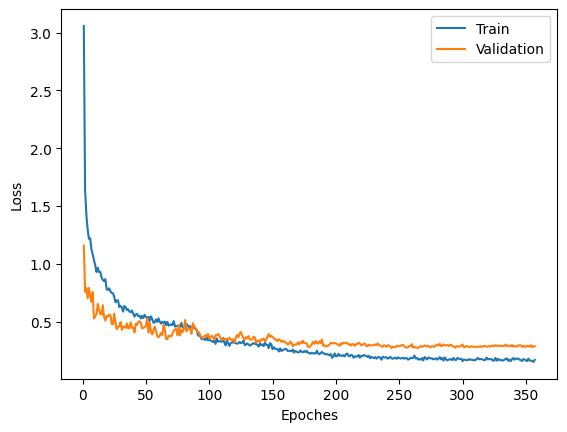

In [13]:
plot_loss(history)


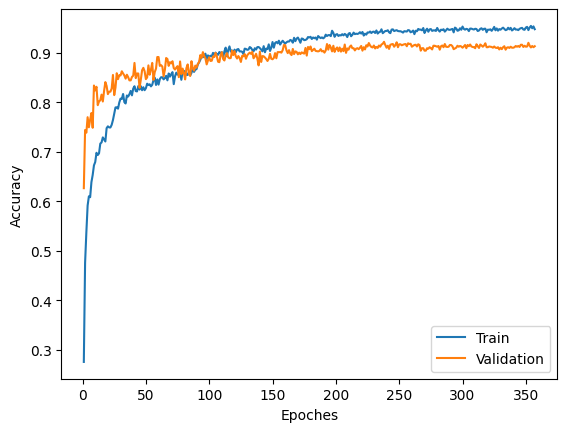

In [14]:
plot_acc(history)


## Testing


In [15]:
# model_path = "model/modelName/savedName.pth"
# bestd_model.load_state_dict(torch.load(model_path, map_location=device))


In [16]:
# Make sure the model is in eval mode.
# Some modules like Dropout or BatchNorm affect if the model is in training mode.
bestd_model.eval()

# Initialize a list to store the predictions.
predictions = []

# Iterate the testing set by batches.
for batch in tqdm(test_loader):
    # A batch consists of image data and corresponding labels.
    # But here the variable "labels" is useless since we do not have the ground-truth.
    # If printing out the labels, you will find that it is always 0.
    # This is because the wrapper (DatasetFolder) returns images and labels for each batch,
    # so we have to create fake labels to make it work normally.
    imgs, labels = batch

    # We don't need gradient in testing, and we don't even have labels to compute loss.
    # Using torch.no_grad() accelerates the forward process.
    with torch.no_grad():
        logits = bestd_model(imgs.to(device))

    # Take the class with greatest logit as prediction and record it.
    predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())


  0%|          | 0/67 [00:00<?, ?it/s]

In [17]:
# Save predictions into the file.
with open("predict.csv", "w") as f:

    # The first row must be "Id, Category"
    f.write("Id,Category\n")

    # For the rest of the rows, each image id corresponds to a predicted class.
    for i, pred in enumerate(predictions):
        f.write(f"{i},{pred}\n")
